In [246]:
import numpy as np
from numpy import linalg
import cvxopt
import cvxopt.solvers
import matplotlib.pyplot as plt
import pandas as pd

In [247]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def polynomial_kernel(x, y, p=3):
    return (1 + np.dot(x, y)) ** p

def gaussian_kernel(x, y, sigma=5.0):
    return np.exp(-linalg.norm(x-y)**2 / (2 * (sigma ** 2)))

In [248]:
class SVM(object):

    def __init__(self, kernel=linear_kernel, C=None):
        self.kernel = kernel
        self.C = C
        if self.C is not None:
            self.C = float(self.C)

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])
        
        P = cvxopt.matrix(np.outer(y,y) * K)
        q = cvxopt.matrix(np.ones(n_samples) * -1)
        A = cvxopt.matrix(y, (1,n_samples))
        b = cvxopt.matrix(0.0)

        if self.C is None:
            G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
            h = cvxopt.matrix(np.zeros(n_samples))
        else:
            tmp1 = np.diag(np.ones(n_samples) * -1)
            tmp2 = np.identity(n_samples)
            G = cvxopt.matrix(np.vstack((tmp1, tmp2)))
            tmp1 = np.zeros(n_samples)
            tmp2 = np.ones(n_samples) * self.C
            h = cvxopt.matrix(np.hstack((tmp1, tmp2)))

        solution = cvxopt.solvers.qp(P, q, G, h, A, b)

        a = np.ravel(solution['x'])
        print(a)
        print(np.amax(a))
        
        sv = a > 1e-05
        ind = np.arange(len(a))[sv]
        self.a = a[sv]
        self.sv = X[sv]
        self.sv_y = y[sv]

        self.b = 0
        for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n],sv])
        self.b /= len(self.a)

        if self.kernel == linear_kernel:
            self.w = np.zeros(n_features)
            for n in range(len(self.a)):
                self.w += self.a[n] * self.sv_y[n] * self.sv[n]
        else:
            self.w = None
#         self.w = ((y * a).T @ X).reshape(-1,1)
#         S = (a > 1e-05).flatten()
#         self.b = (y[S] - np.dot(X[S], self.w))
#         self.b = np.sum(self.b[0])

    def project(self, X):
        if self.w is not None:
            return np.dot(X, self.w) + self.b
        else:
            y_predict = np.zeros(len(X))
            for i in range(len(X)):
                s = 0
                for a, sv_y, sv in zip(self.a, self.sv_y, self.sv):
                    s += a * sv_y * self.kernel(X[i], sv)
                y_predict[i] = s
            return y_predict + self.b[0]

    def predict(self, X):
        return (self.project(X))

In [249]:
X = np.sort(5 * np.random.rand(40, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(8))
print(X)
print(y)

[[0.08977462]
 [0.18139253]
 [0.34986759]
 [0.35400695]
 [0.62477122]
 [0.88554704]
 [0.90751064]
 [1.10452665]
 [1.15946897]
 [1.2498337 ]
 [1.29050504]
 [1.33237505]
 [1.49608268]
 [1.80082307]
 [1.80673913]
 [1.8134533 ]
 [1.83640444]
 [1.87310149]
 [2.01813388]
 [2.13559464]
 [2.21038748]
 [2.30768282]
 [2.47259808]
 [2.54218207]
 [2.6301282 ]
 [2.6353407 ]
 [2.73769341]
 [2.83277594]
 [2.86823133]
 [2.88139183]
 [2.9473787 ]
 [2.96413096]
 [3.07643145]
 [3.21738228]
 [3.35395202]
 [3.58218948]
 [4.28064514]
 [4.44766912]
 [4.63221499]
 [4.67115381]]
[-1.1831516   0.18039943  0.34277342  0.34665906  0.58491173  0.92894613
  0.78797346  0.89325149  0.91659092  0.94893217  1.98342934  0.97171203
  0.99721023  0.9736603   0.97229438  0.24774934  0.96493305  0.95465273
  0.90160198  0.84469657  0.22022691  0.74056438  0.6201976   0.56415591
  0.48945482  1.67652989  0.39300681  0.30393154  0.26996947  0.25727463
  0.29001128  0.17653171  0.0651151  -0.07571709 -0.21076685 -0.6349229
 -

In [250]:
clf = SVM(C=0.05)
clf.fit(X,y)
print(clf.w)
print(clf.b)

     pcost       dcost       gap    pres   dres
 0: -1.2915e+01 -5.3254e+00  4e+02  2e+01  2e-15
 1: -1.1071e+00 -5.2083e+00  1e+01  4e-01  2e-15
 2: -8.8146e-01 -2.4899e+00  2e+00  2e-04  8e-16
 3: -1.0323e+00 -1.2718e+00  2e-01  2e-05  7e-16
 4: -1.1289e+00 -1.1847e+00  6e-02  5e-06  6e-16
 5: -1.1449e+00 -1.1656e+00  2e-02  2e-06  4e-16
 6: -1.1545e+00 -1.1567e+00  2e-03  6e-17  4e-16
 7: -1.1555e+00 -1.1555e+00  3e-05  7e-17  5e-16
 8: -1.1555e+00 -1.1555e+00  3e-07  7e-17  4e-16
Optimal solution found.
[4.99999991e-02 4.99999951e-02 4.99999910e-02 4.99999909e-02
 1.17431355e-07 5.32174114e-09 8.83166343e-09 6.75056404e-09
 6.49346361e-09 6.24516376e-09 1.55219173e-09 6.17214537e-09
 6.41012597e-09 8.62966954e-09 8.70848221e-09 4.99999952e-02
 9.13180650e-09 9.71973829e-09 1.08407617e-08 2.75764987e-02
 4.99999957e-02 4.99999732e-02 4.99999900e-02 4.99999917e-02
 4.99999933e-02 4.41682717e-09 4.99999947e-02 4.99999955e-02
 4.99999957e-02 4.99999958e-02 4.99999956e-02 4.99999962e-02

R^2: 0.16644696976375672
MAE: 0.49650334200325774
MSE: 0.4171712101557038
RMSE: 0.6458879238348584


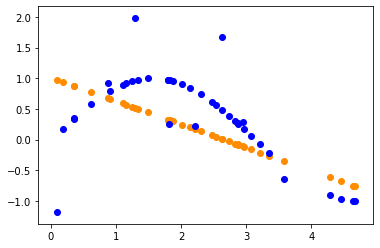

In [251]:
y_pred_prac = clf.predict(X)
plt.scatter(X, y_pred_prac, color='darkorange', label='data')
plt.scatter(X, y, color='blue', label='data')

from sklearn import metrics
print('R^2:',metrics.r2_score(y, y_pred_prac))
print('MAE:',metrics.mean_absolute_error(y, y_pred_prac))
print('MSE:',metrics.mean_squared_error(y, y_pred_prac))
print('RMSE:',np.sqrt(metrics.mean_squared_error(y, y_pred_prac)))

In [252]:
from sklearn.datasets import load_boston
boston = load_boston()

In [253]:
data = pd.DataFrame(boston.data)
data.columns = boston.feature_names
data['PRICE'] = boston.target 
raw = []
for i in data.columns:
    raw.append(data[i])
raw = np.asarray(raw).transpose()
raw

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 3.9690e+02, 4.9800e+00,
        2.4000e+01],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 3.9690e+02, 9.1400e+00,
        2.1600e+01],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 3.9283e+02, 4.0300e+00,
        3.4700e+01],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 5.6400e+00,
        2.3900e+01],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 3.9345e+02, 6.4800e+00,
        2.2000e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 7.8800e+00,
        1.1900e+01]])

In [254]:
X = raw[:, 0:13]
Y = raw[:, 13:14]
for i in range(0, len(X[0])):
    X[:, i] = (X[:, i] - np.mean(X[:, i]))/np.amax(X[:, i])
meanPrice = np.mean(Y)
maxPrice = np.amax(Y)
Y = (Y-np.mean(Y))/np.amax(Y)
print(X)
print(Y)

[[-0.04054122  0.06636364 -0.31819678 ... -0.14343335  0.10135039
  -0.20208226]
 [-0.04030531 -0.11363636 -0.14660341 ... -0.02979698  0.10135039
  -0.09252208]
 [-0.04030554 -0.11363636 -0.14660341 ... -0.02979698  0.09109591
  -0.22710201]
 ...
 [-0.03992937 -0.11363636  0.02859486 ...  0.11565756  0.10135039
  -0.18470011]
 [-0.03938057 -0.11363636  0.02859486 ...  0.11565756  0.09265802
  -0.16257738]
 [-0.04007941 -0.11363636  0.02859486 ...  0.11565756  0.10135039
  -0.12570617]]
[[ 0.02934387]
 [-0.01865613]
 [ 0.24334387]
 [ 0.21734387]
 [ 0.27334387]
 [ 0.12334387]
 [ 0.00734387]
 [ 0.09134387]
 [-0.12065613]
 [-0.07265613]
 [-0.15065613]
 [-0.07265613]
 [-0.01665613]
 [-0.04265613]
 [-0.08665613]
 [-0.05265613]
 [ 0.01134387]
 [-0.10065613]
 [-0.04665613]
 [-0.08665613]
 [-0.17865613]
 [-0.05865613]
 [-0.14665613]
 [-0.16065613]
 [-0.13865613]
 [-0.17265613]
 [-0.11865613]
 [-0.15465613]
 [-0.08265613]
 [-0.03065613]
 [-0.19665613]
 [-0.16065613]
 [-0.18665613]
 [-0.18865613

In [255]:
clf = SVM(C=0.01)

In [256]:
clf.fit(X,Y)

     pcost       dcost       gap    pres   dres
 0: -1.9286e+02 -1.9958e+01  4e+03  6e+01  1e-15
 1: -2.3987e+01 -1.4457e+01  3e+02  5e+00  1e-15
 2: -3.3640e+00 -1.2511e+01  1e+01  7e-02  2e-15
 3: -3.7897e+00 -7.1501e+00  4e+00  2e-02  9e-16
 4: -4.5979e+00 -5.6685e+00  1e+00  2e-03  9e-16
 5: -5.0025e+00 -5.0258e+00  2e-02  5e-05  1e-15
 6: -5.0153e+00 -5.0155e+00  2e-04  5e-07  1e-15
 7: -5.0154e+00 -5.0154e+00  2e-06  5e-09  9e-16
Optimal solution found.
[0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.01       0.01
 0.01       0.01       0.01       0.01       0.0

In [257]:
y_pred = clf.predict(X)
y_pred = (y_pred*maxPrice)+meanPrice
Y = (Y*maxPrice)+meanPrice

In [258]:
print(clf.w)
print(clf.b)

[-0.03486964  0.0780883  -0.11112481  0.04135034 -0.052809    0.05168997
 -0.09856488  0.0403136  -0.12861179 -0.10316709 -0.04641709  0.0712496
 -0.12887016]
[-7.88930639e-17]


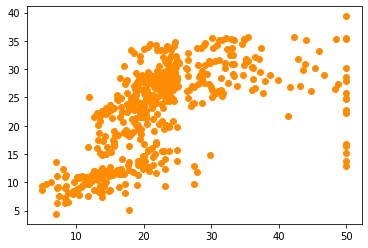

In [259]:
plt.scatter(Y, y_pred, color='darkorange', label='data')

In [260]:
from sklearn import metrics
print('R^2:',metrics.r2_score(Y, y_pred))
print('MAE:',metrics.mean_absolute_error(Y, y_pred))
print('MSE:',metrics.mean_squared_error(Y, y_pred))
print('RMSE:',np.sqrt(metrics.mean_squared_error(Y, y_pred)))

R^2: 0.28239079153236035
MAE: 5.689463946054603
MSE: 60.58025087241542
RMSE: 7.783331604937272
